In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt

import time

In [2]:
# Load CIFAR10 dataset
(training_set, validation_set), dataset_info = tfds.load(
    'cifar10',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
# Look at the shape of our dataset
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1

for example in validation_set:
    num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 10
Total Number of Training Images: 35000
Total Number of Validation Images: 15000 



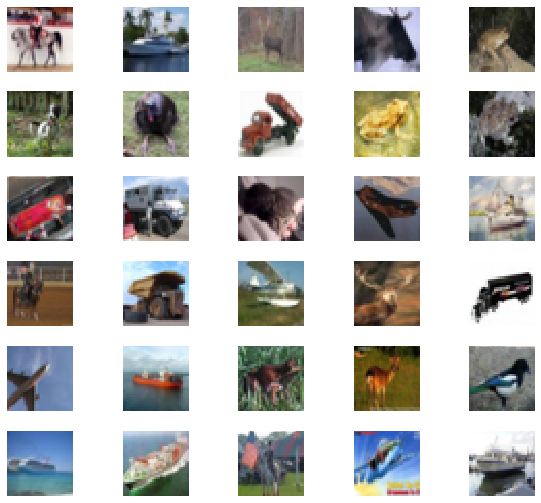

In [4]:
# Check out a few specific samples
image_batch = []
for i, example in enumerate(training_set.take(30)):
    image_batch.append(example[0])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.axis('off')

In [5]:
# Reformat to fit MobileNet V2 and split into batches
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 64

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [6]:
# Setup MobileNet V2 feature extractor
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [7]:
# Freeze layers of pretrained model
feature_extractor.trainable = False

In [10]:
# Attach classification head
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
# Train our classification head to take input from our feature extractor
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 3

earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=1)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches, 
                    callbacks = [earlystop_callback])

Epoch 1/3
547/547 [==============================] - 1310s 2s/step - loss: 0.6476 - accuracy: 0.7790 - val_loss: 0.4802 - val_accuracy: 0.8372
Epoch 2/3
547/547 [==============================] - 1033s 2s/step - loss: 0.4412 - accuracy: 0.8484 - val_loss: 0.4525 - val_accuracy: 0.8445
Epoch 3/3
547/547 [==============================] - 1225s 2s/step - loss: 0.4062 - accuracy: 0.8597 - val_loss: 0.4545 - val_accuracy: 0.8433


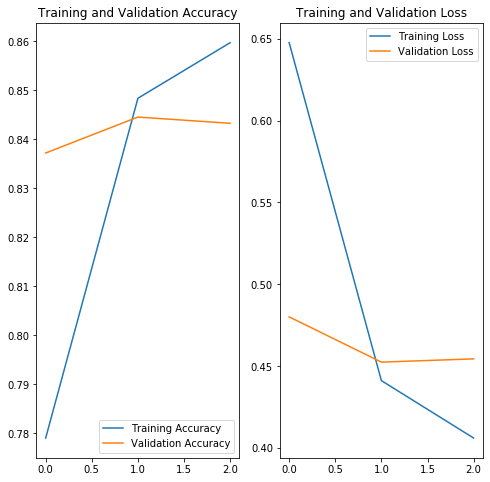

In [16]:
# Plot valid accuracy / loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [18]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['truck' 'ship' 'cat' 'frog' 'frog' 'bird' 'cat' 'bird' 'airplane' 'ship'
 'horse' 'horse' 'frog' 'airplane' 'automobile' 'horse' 'horse' 'truck'
 'dog' 'truck' 'bird' 'deer' 'automobile' 'bird' 'frog' 'bird' 'cat' 'dog'
 'truck' 'airplane' 'frog' 'dog' 'cat' 'bird' 'deer' 'cat' 'truck' 'frog'
 'ship' 'frog' 'deer' 'airplane' 'bird' 'cat' 'horse' 'horse' 'frog'
 'deer' 'frog' 'automobile' 'airplane' 'horse' 'cat' 'horse' 'airplane'
 'bird' 'ship' 'truck' 'frog' 'frog' 'ship' 'deer' 'bird' 'airplane']


In [19]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [9 8 0 0 6 2 3 2 0 8 7 7 6 0 1 7 7 9 5 9 2 7 1 2 2 2 5 5 0 0 6 5 3 2 4 0 9
 6 7 6 4 0 2 3 7 7 4 4 6 1 0 7 3 7 0 2 8 9 4 6 8 4 4 0]
Predicted labels:  [9 8 3 6 6 2 3 2 0 8 7 7 6 0 1 7 7 9 5 9 2 4 1 2 6 2 3 5 9 0 6 5 3 2 4 3 9
 6 8 6 4 0 2 3 7 7 6 4 6 1 0 7 3 7 0 2 8 9 6 6 8 4 2 0]


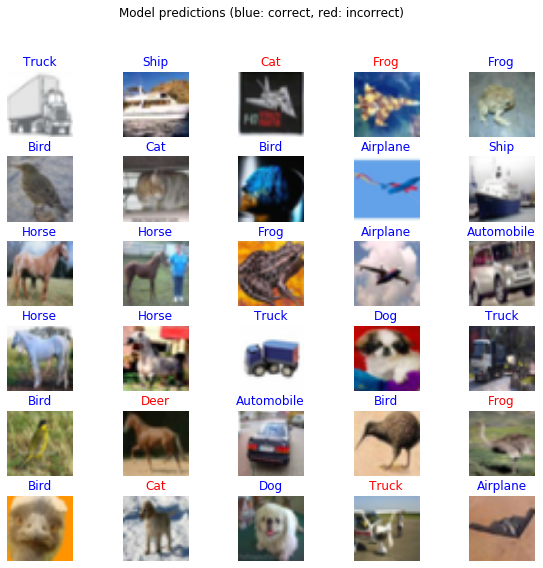

In [20]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [21]:
# setup model with Inception V3 pretrained model as feature extractor
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'cifar10', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 1

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [ ]:
# Plot valid accuracy / loss graphs (Adjust EPOCHS for longer training to achieve higher accuracy and 
#                                        more useful visualizations)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
t = time.time()

# Save Mobilenet Model in Keras' h5 format and TF SavedModel format
mobilenet_export_path_keras = "./mobilenet{}.h5".format(int(t))
print(mobilenet_export_path_keras)
model.save(mobilenet_export_path_keras)

mobilenet_export_path_sm = "./mobilenet{}".format(int(t))
print(mobilenet_export_path_sm)
tf.saved_model.save(model, mobilenet_export_path_sm)

# Save Inception Model in Keras' h5 format and TF SavedModel format
inception_export_path_keras = "./inception{}.h5".format(int(t))
print(inception_export_path_keras)
model_inception.save(inception_export_path_keras)

inception_export_path_sm = "./inception{}".format(int(t))
print(inception_export_path_sm)
tf.saved_model.save(model_inception, inception_export_path_sm)

./mobilenet1591336460.h5
./mobilenet1591336460
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./mobilenet1591336460\assets


INFO:tensorflow:Assets written to: ./mobilenet1591336460\assets


./inception1591336460.h5
./inception1591336460
INFO:tensorflow:Assets written to: ./inception1591336460\assets


INFO:tensorflow:Assets written to: ./inception1591336460\assets
